# Generating t-SNE plots

This notebook creates t-SNE plots for visualizing the outputs of certain layers of the RoBERTa model, fragment 128, IMSLP pretrained on the fullpage data and unseen composers. It also prepares the unseen composer data.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.text import *
from transformers import RobertaForSequenceClassification, RobertaConfig
from train_utils import *
import tokenizers
from fastai.callbacks.hooks import *
from plotnine import *
from sklearn.manifold import TSNE

In [4]:
torch.cuda.set_device(1)

### Prepare unseen composer data

First we select our unseen composers, and select the corresponding bootleg scores from the entire IMSLP piano bootleg score dataset.

In [5]:
imslp_bscores_filelist = 'imslp_bscores.list'
data_path = Config.data_path()/'others'
data_path.mkdir(exist_ok=True)
composers = ['Tchaikovsky', 'Clementi', 'Pachelbel', 'Debussy', 'Joplin']

In [6]:
def bscore2textfile(infile, outfile, min_thresh = 100):
    '''
    Converts a bootleg score .pkl file to text and writes to the specified output file.
    '''
    with open(infile, 'rb') as f:
        d = pickle.load(f)
    
    with open(outfile, 'w') as fout:
        for l in d: # each page
            if len(l) > min_thresh: # to avoid filler pages
                pageStr = ' '.join([str(i) for i in l])
                fout.write(pageStr)

In [7]:
def imslp2text(filelist, outdir):
    from pathlib import Path
    with open(filelist, 'r') as f:
        for line in f:
            bscorefile = Path(line.strip()) # path/composer/piece/283513.pkl
            fileid = bscorefile.name[:-4] # e.g. 283513
            composer = str(bscorefile.parent.parent.name).split(',')[0]
            if composer in composers:
                Path(outdir/f'{composer}').mkdir(exist_ok=True)
                outfile = outdir/f'{composer}'/f'{fileid}.txt'
                bscore2textfile(bscorefile, outfile)

In [8]:
from pathlib import Path
from collections import defaultdict
composer_data = defaultdict(int)
with open(imslp_bscores_filelist) as f:
    for line in f:
        bscorefile = Path(line.strip()) # path/composer/piece/283513.pkl
        composer = str(bscorefile.parent.parent.name).split(',')[0]
        composer_data[composer] += 1

data = {'composers': list(composer_data.keys()), 'counts' : list(composer_data.values())}
composer_df = pd.DataFrame.from_dict(data)
composer_df = composer_df.sort_values(by=['counts'], ascending=False)

In [10]:
imslp2text(imslp_bscores_filelist, data_path)

Then we convert the data for the selected unseen composers into csv files.

In [12]:
def generateFullPageCSV(directory, outfile):
    with open(outfile, 'w') as fout:
        fout.write('label,text\n')
        for fileDir in directory.rglob('*.txt'): # others/composer/file_id.txt
            composer = fileDir.parent.name
            with open(fileDir, 'r') as text_file:
                text = text_file.read()
                fout.write(f'{composer},{text}\n')
    df = pd.read_csv(outfile)
    df.dropna(inplace=True)
    df.to_csv(outfile)

In [13]:
generateFullPageCSV(data_path, data_path/'others.fullpage.csv')

Because we are using RoBERTa, we need to convert the data into the proper format for Transformer-based models. Instead of using decimal string representations, we represent each 62-bit bootleg score feature as a sequence of 8 one-byte characters. Rather than generating these from scratch, we will simply convert the existing files to the new format.

In [14]:
def convertLineToCharSeq(line):
    ints = [int(p) for p in line.split()]
    result = ' '.join([int2charseq(i) for i in ints])
    return result

In [15]:
def int2charseq(int64):
    chars = ''
    for i in range(8):
        numshift = i * 8
        charidx = (int64 >> numshift) & 255
        chars += chr(19968 + charidx) # 19968 ensures that all chars are chinese characters (not newline, space, etc)
    return ''.join(chars)

In [16]:
def convertSingleCSVFile(infile, outfile):
    '''
    Convert .csv file with decimal string representation of bootleg score features to
    a .csv file with byte character representation.
    '''
    with open(infile, 'r') as f:
        lines = f.readlines()
    with open(outfile, 'w') as fout:
        for i, line in enumerate(lines):
            if i==0: 
                fout.write(line) # header
            else:
                parts = line.strip().split(',')
                feats = parts.pop()
                charseq = convertLineToCharSeq(feats)
                strToWrite = ','.join(parts) + ',' + charseq + '\n'
                fout.write(strToWrite)

In [17]:
convertSingleCSVFile(data_path/'others.fullpage.csv', data_path/'others.fullpage128.csv')

### Hook to store outputs of intermediate layers

We use a PyTorch hook to store the outputs of a given layer.

In [56]:
class StoreHook(Callback):
    def __init__(self, module):
        super().__init__()
        self.custom_hook = hook_output(module)
        self.outputs = []
        
    def on_batch_end(self, train, **kwargs): 
        if (not train): self.outputs.append(self.custom_hook.stored)

### Functions for making t-SNE

We get the outputs of our hook and then make a t-SNE plot of these outputs  the model's predicted composer.

In [52]:
def get_hook_outputs(hook, y, is_penult_layer=False):
    """ given a hook for a model, get the hook outputs at the given layer """
    num_outputs = len(y)
    outputs = []
    for output in hook.outputs:
        if is_penult_layer:
            # get the first token for RoBERTa because that's what it uses for prediction
            outputs.append(output[:, 0, :])
        else:
            outputs.append(output)
    outputs = torch.cat(outputs)[-num_outputs:].cpu().numpy()
    return outputs

In [53]:
def plot_tSNE(x, y):
    num_classes = len(np.unique(y))
    tsne = TSNE(n_components=2, random_state=0)
    tsne_obj = tsne.fit_transform(x)
    tsne_df = pd.DataFrame({'X': tsne_obj[:, 0],
                           'Y': tsne_obj[:, 1],
                           'composer': y})
    plt.figure(figsize=(16, 10))
    legend_position = "right"
    return (ggplot(tsne_df, aes(x="X", y="Y")) + 
        geom_point(aes(color = 'factor(composer)'), alpha=0.8) +
        theme_bw() +
        guides(colour = guide_legend(override_aes = {'alpha': 1})) +
        theme(dpi=300, legend_title=element_blank(), legend_key=element_blank(), 
            axis_text_x = element_blank(),
            axis_text_y = element_blank(),
            axis_title_x = element_blank(),
            axis_title_y = element_blank(),
            axis_ticks = element_blank()))

# RoBERTa

### Prep databunch

In [21]:
bs = 64
seed = 42
tok_model_dir = '/home/tjtsai/.fastai/data/bscore_lm/bpe_data/tokenizer_imslp'
max_seq_len = 256

In [22]:
cust_tok = CustomTokenizer(TransformersBaseTokenizer, tok_model_dir, max_seq_len)
transformer_base_tokenizer = TransformersBaseTokenizer(tok_model_dir, max_seq_len)
transformer_vocab =  TransformersVocab(tokenizer = transformer_base_tokenizer._pretrained_tokenizer)

In [23]:
pad_idx = transformer_base_tokenizer._pretrained_tokenizer.token_to_id('<pad>')

In [24]:
bpe_path = Path('/home/tjtsai/.fastai/data/bscore_lm/bpe_data')
train_df = pd.read_csv(bpe_path/'train128.char.csv')
valid_df = pd.read_csv(bpe_path/'valid128.char.csv')
test_df = pd.read_csv(bpe_path/'test128.char.csv')

In [25]:
data_clas = TextDataBunch.from_df(bpe_path, train_df, valid_df, tokenizer=cust_tok, vocab=transformer_vocab,
                                  include_bos=False, include_eos=False, pad_first=False, pad_idx=pad_idx, 
                                  bs=bs, num_workers=1)

### Load RoBERTa Classifier

In [26]:
model_class, config_class = RobertaForSequenceClassification, RobertaConfig
model_path = '/home/tjtsai/.fastai/data/bscore_lm/bpe_data/models/roberta_train-imslp_finetune-target_lm'

In [27]:
config = config_class.from_pretrained(model_path)
config.num_labels = data_clas.c

In [28]:
transformer_model = model_class.from_pretrained(model_path, config = config)
custom_transformer_model = RobertaModelWrapper(transformer_model, pad_idx)

In [29]:
learner = Learner(data_clas, custom_transformer_model, metrics=[accuracy, FBeta(average='macro', beta=1)])
model_path = "/home/kji/.fastai/models"
learner.load(f'{model_path}/roberta_train-imslp_finetune-target_clas_128')

Learner(data=TextClasDataBunch;

Train: LabelList (16200 items)
x: TextList
<s> 一一亀一乀一一一</w> 一一一丂一一一一</w> 一一丠一一丁一一</w> 一一一丂一一一一</w> 一一一丁乀丄一一</w> 一一亀一一一一一</w> 一一乀一么丄一一</w> 一一亀一一一一一</w> 一一乀 一乐丈一一</w> 一一丠一一一一一</w> 一一亀一一一一一</w> 一一乀一丠丐一一</w> 一一一丂一一一一</w> 一一亀一一一一一</w> 一一丠一一一一一</w> 一一乀一一一一一</w> 一一亀一乀丄一一</w> 一一一丂一一一一</w> 一一乀一丠丐一一</w> 一一一丂一一一一</w> 一一一丁亀丈一一</w> 一一一丂一一一一</w> 一一乀一丠一一一</w> 一一一丂一丐一一</w> 一一亀一乀一一一</w> 一一一丂一一一一</w> 一一丠一一丁一一</w> 一一一丂一一一一</w> 一一一丁乀丄一一</w> 一一亀一一一一一</w> 一一丈一一一一一</w> 一一乀一么丄一一</w> 一一亀一一一一一</w> 一一乀一一丈一一</w> 一一丠一一一一一</w> 一一亀一一一一一</w> 一一乀一丠丐一一</w> 一一乀一一一一一</w> 一一亀一一一一一</w> 一一一丁一一一一</w> 一一一丂一一一一</w> 一一一丂一一一一</w> 一一一丄一一一一</w> 一一乁 一乀丠一一</w> 一一亄一一一一一</w> 一一乀丁丠丐一一</w> 一一亄一一一一一</w> 一一乁一一一一一</w> 一一亄一乀丠一一</w> 一一両一一一一一</w> 一一予一一一一一</w> 一一丠丁一一一一</w> 一一予一一一一一</w> 一一両一丐丈一一</w> 一一予一一一一一</w> 一一乁 一乀丠一一</w> 一一亄一一一一一</w> 一一乀丁丠丐一一</w> 丠 一亄 一一一一一</w> 一一乁一一一一一</w> 一一亄一乀丠一一</w> 一一丈一一一一一</w> 一一両一一一一一</w> 一一予一一一一一</w> 一一丠丁一一一一</w> 一一予一一一一一</w> 一一丠一丐丈一一</w> 一一予一一一一一</w> 一一両一亀乀一一</w> 一一丈丁一一一一</w> 一一丠丂乀

In [30]:
seed_all(seed)

In [31]:
penult_layer_hook = StoreHook(list(learner.model.modules())[-8])
last_layer_hook = StoreHook(list(learner.model.modules())[-1])
learner.callbacks += [penult_layer_hook, last_layer_hook]

### Make databunches

In [32]:
train_fullpage_df = pd.read_csv(bpe_path/'train.fullpage.char.csv')
valid_fullpage_df = pd.read_csv(bpe_path/'valid.fullpage.char.csv')
test_fullpage_df = pd.read_csv(bpe_path/'test.fullpage.char.csv')

data_clas_test = TextDataBunch.from_df(bpe_path, train_fullpage_df, valid_fullpage_df, test_fullpage_df,
                                       tokenizer=cust_tok, vocab=transformer_vocab, include_bos=False, 
                                       include_eos=False, pad_first=False, pad_idx=pad_idx, bs=bs, num_workers=1)

In [33]:
data_path = Config.data_path()/'others'
data_path.mkdir(exist_ok=True)

In [34]:
others_df = pd.read_csv(data_path/'others.fullpage128.csv', index_col=[0])
# make all the data in train because we're using it all for evaluation
np.random.seed(42)
train, validate = np.split(others_df.sample(frac=1), [int(.99*len(others_df))])

data_clas_test_others = TextDataBunch.from_df(data_path, train, validate,
                                       tokenizer=cust_tok, vocab=transformer_vocab, include_bos=False, 
                                       include_eos=False, pad_first=False, pad_idx=pad_idx, bs=bs, num_workers=1)

### 1. T-SNE plot of full pages in test set, original 9 composers, penultimate layer (768 dim)

In [35]:
learner.data = data_clas_test

In [36]:
preds, y = learner.get_preds(ds_type=DatasetType.Valid)

In [37]:
pred_to_composer = {i: composer for i, composer in enumerate(learner.data.classes)}
labels = [pred_to_composer[num.item()] for num in y]

In [39]:
points = get_hook_outputs(penult_layer_hook, y, is_penult_layer=True)

<Figure size 1152x720 with 0 Axes>

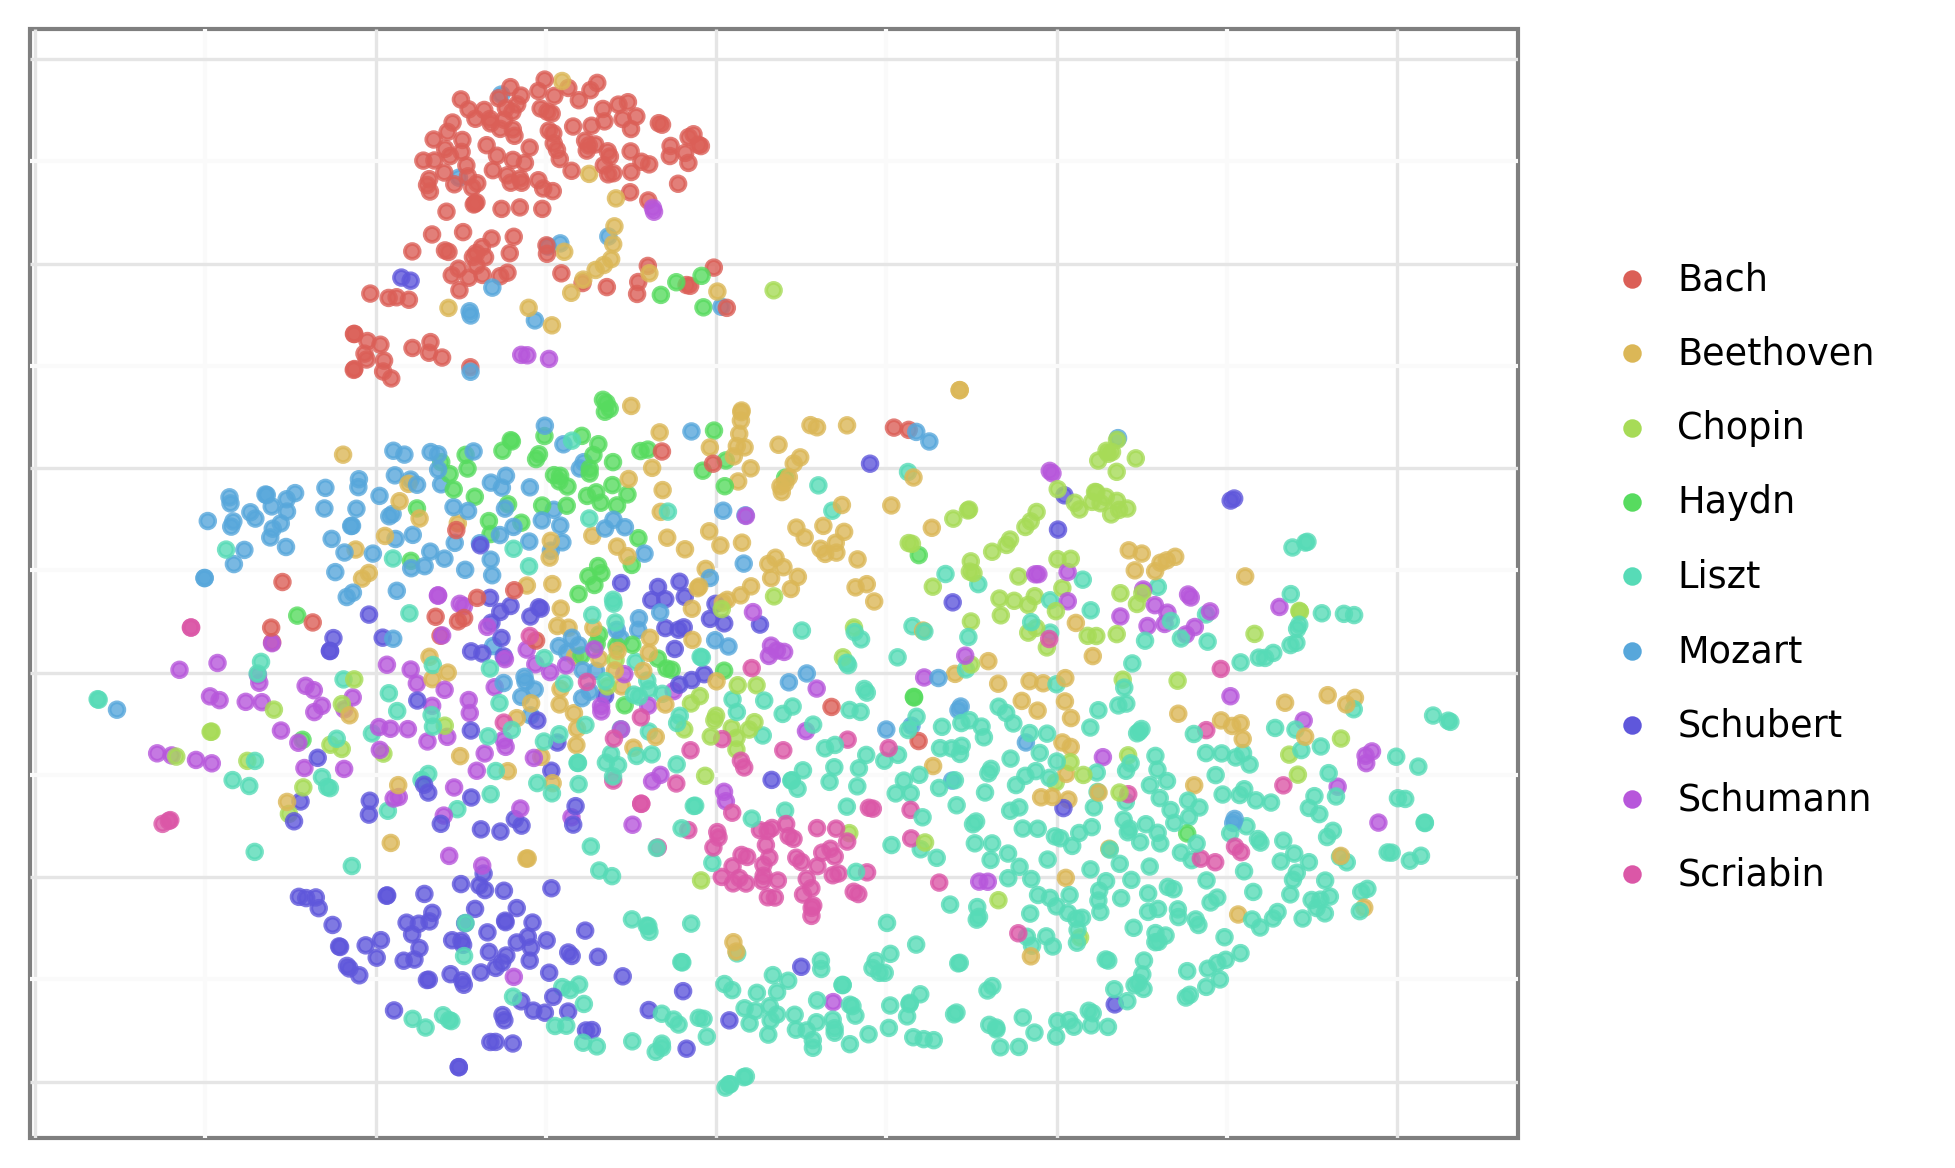

<ggplot: (8792447803119)>

In [41]:
plot_tSNE(points, labels)

### 2. T-SNE plot of full pages in test set, original 9 composers, last layer (9 dim, before softmax)

In [42]:
points = get_hook_outputs(last_layer_hook, y, is_penult_layer=False)

<Figure size 1152x720 with 0 Axes>

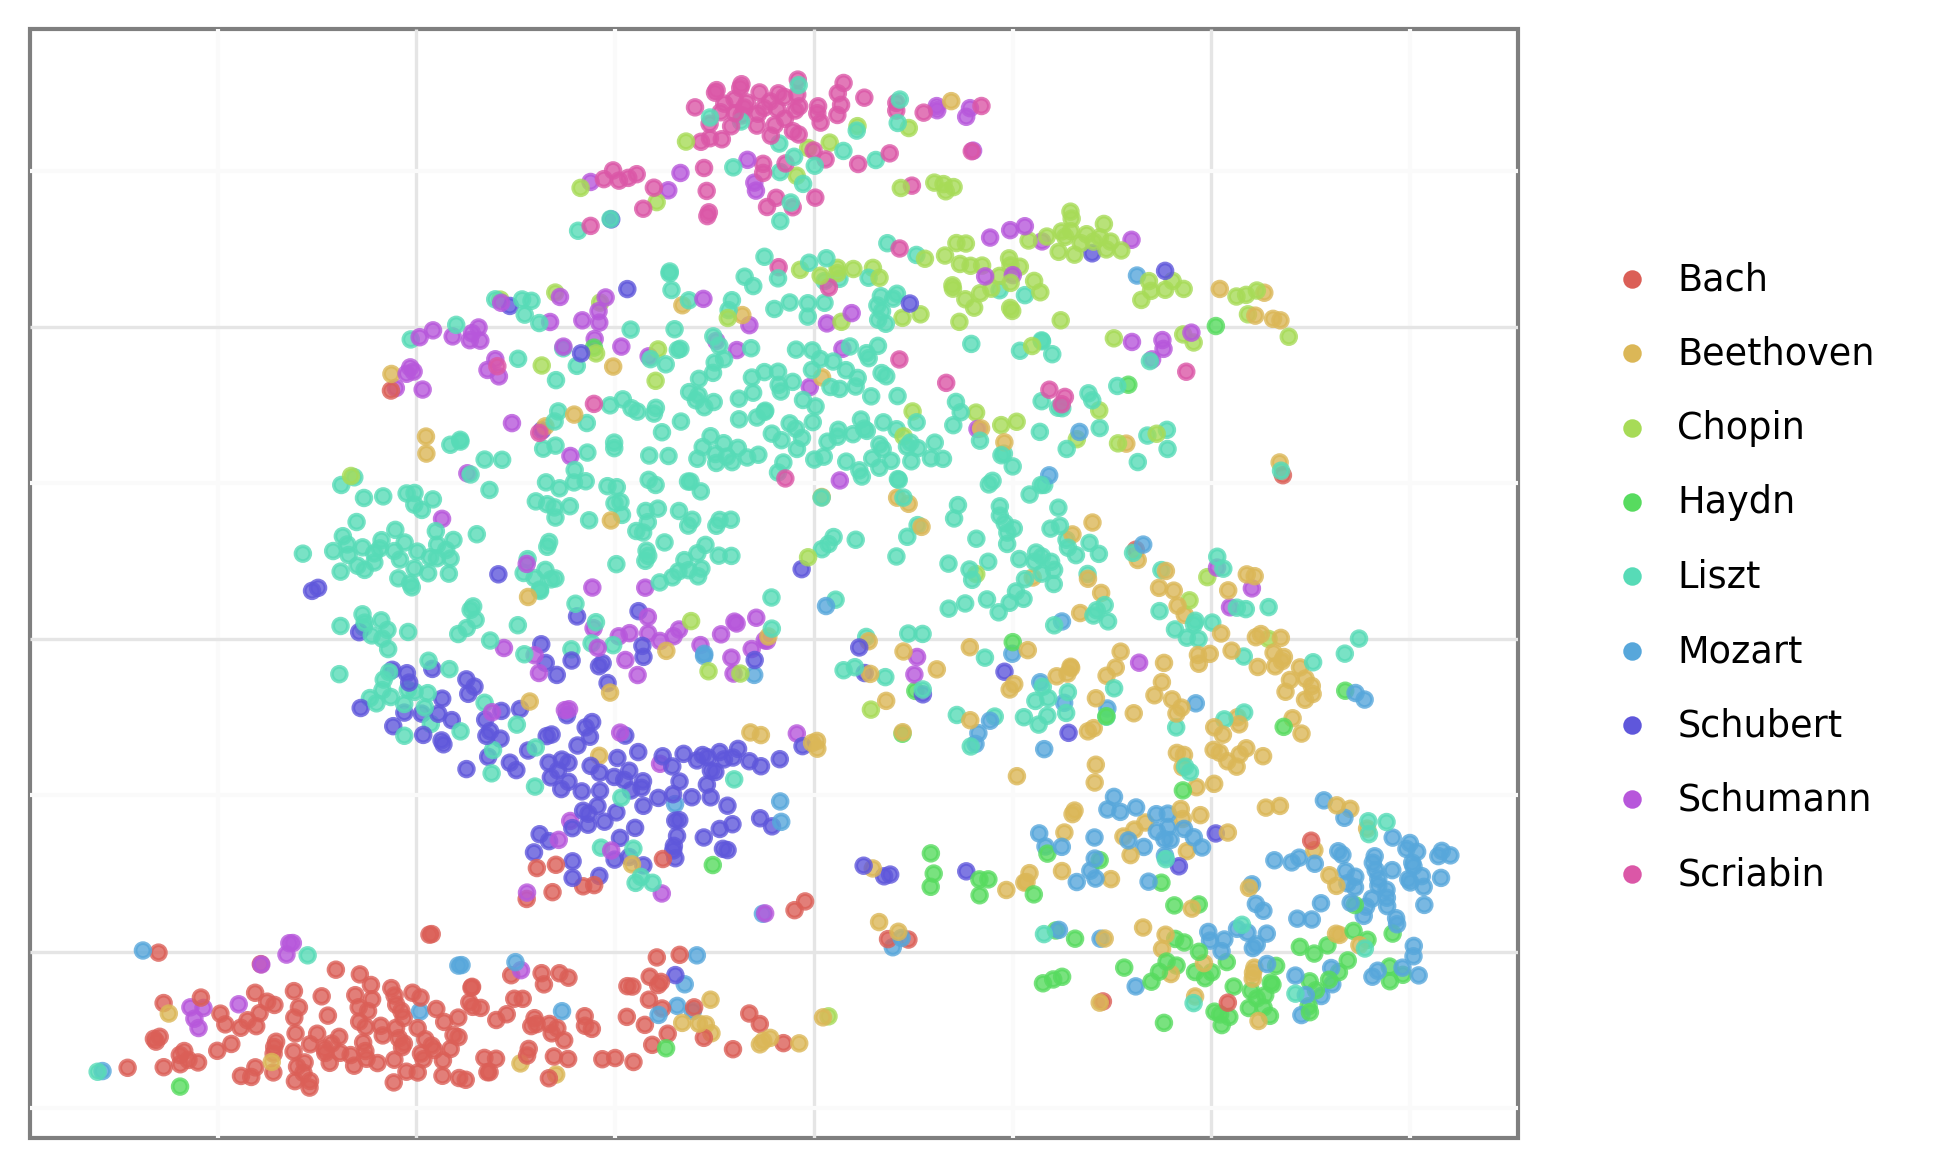

<ggplot: (8792447797312)>

In [43]:
plot_tSNE(points, labels)

### 3.  T-SNE plot of full pages, 5 unseen composers, penultimate layer (768 dim)

In [44]:
learner.data = data_clas_test_others

In [45]:
preds, y = learner.get_preds(ds_type=DatasetType.Train)

In [46]:
pred_to_composer = {i: composer for i, composer in enumerate(learner.data.classes)}
labels = [pred_to_composer[num.item()] for num in y]

In [47]:
points = get_hook_outputs(penult_layer_hook, y, is_penult_layer=True)

<Figure size 1152x720 with 0 Axes>

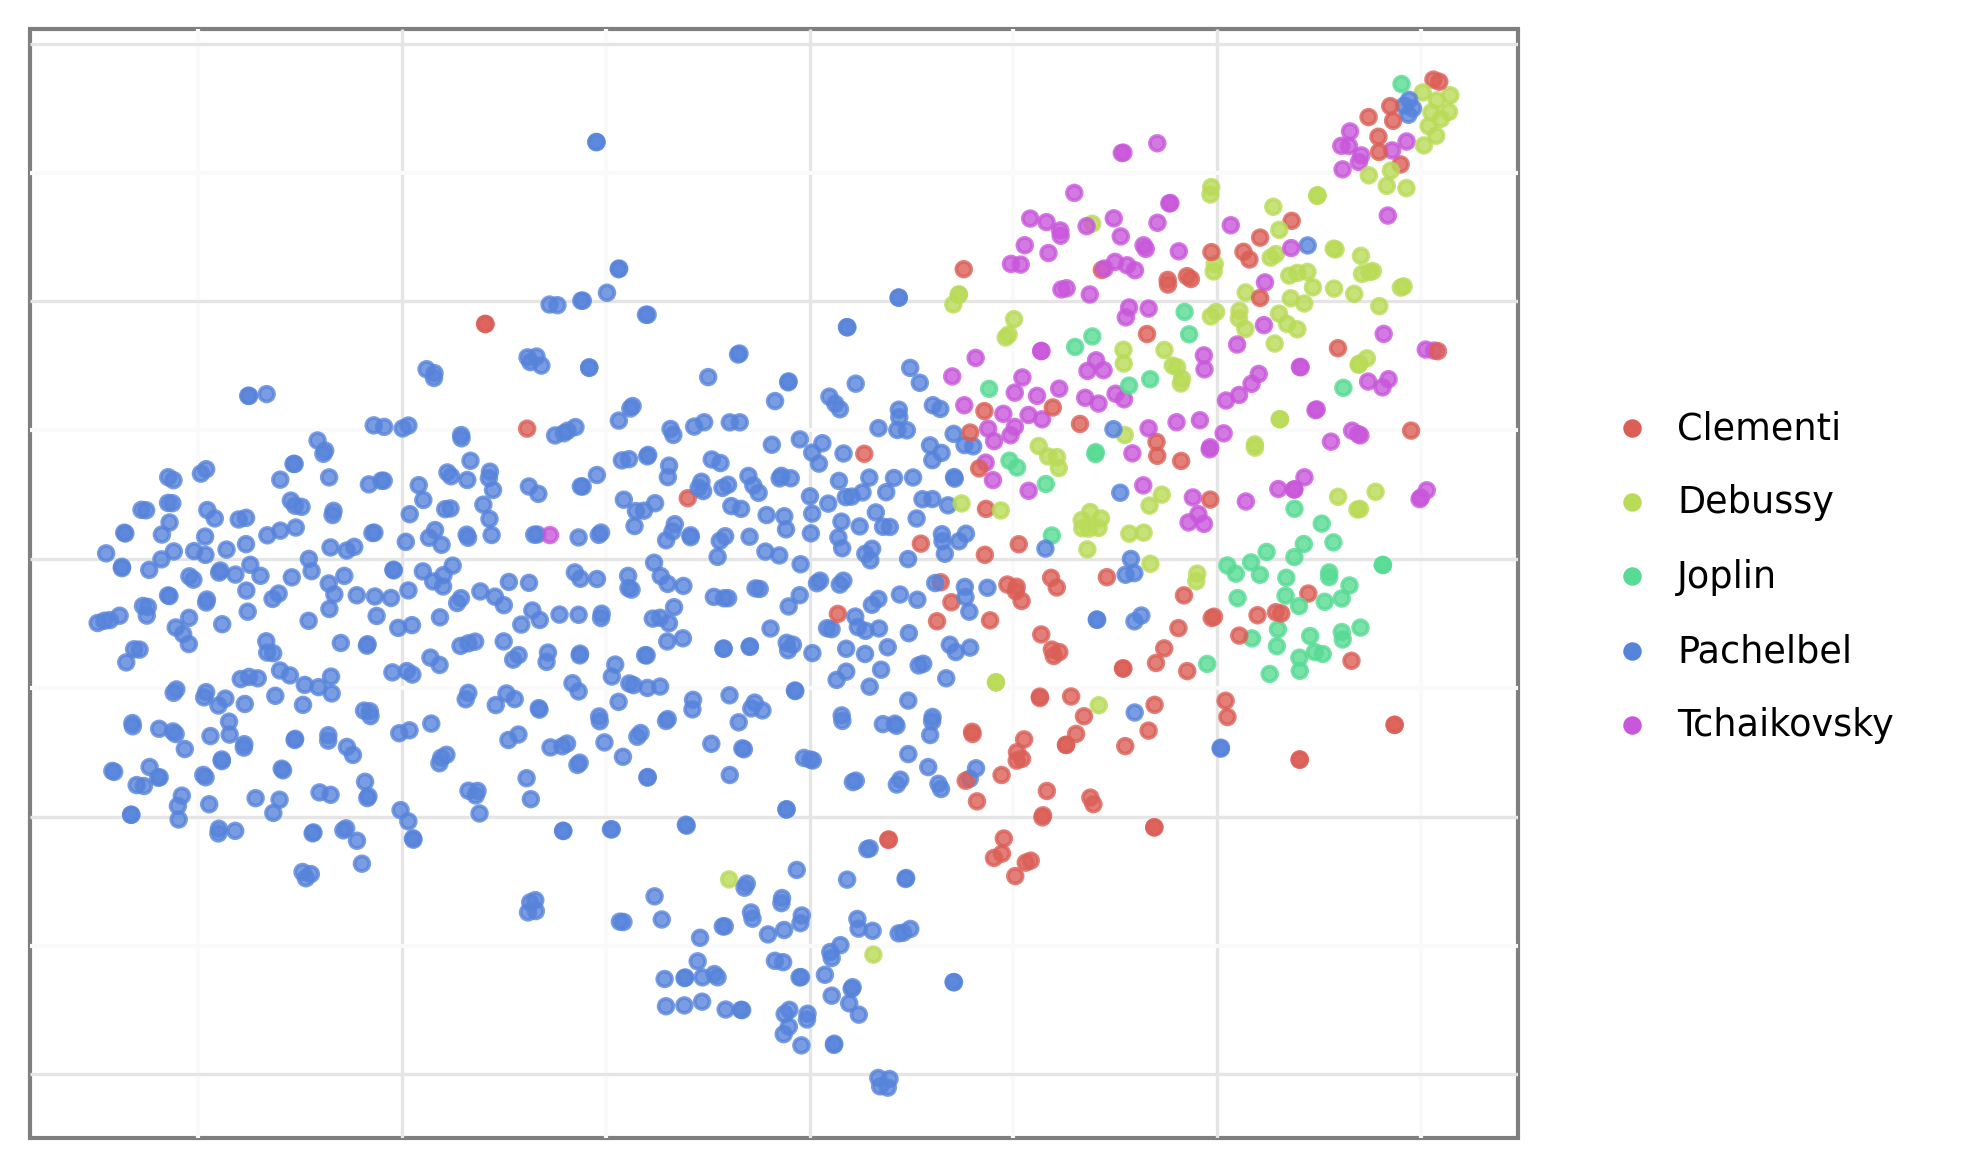

<ggplot: (8792462692742)>

In [48]:
plot_tSNE(points, labels)

### 4. T-SNE plot of full pages, unseen composers, last layer (9 dim, before softmax)

In [49]:
points = get_hook_outputs(last_layer_hook, y)

<Figure size 1152x720 with 0 Axes>

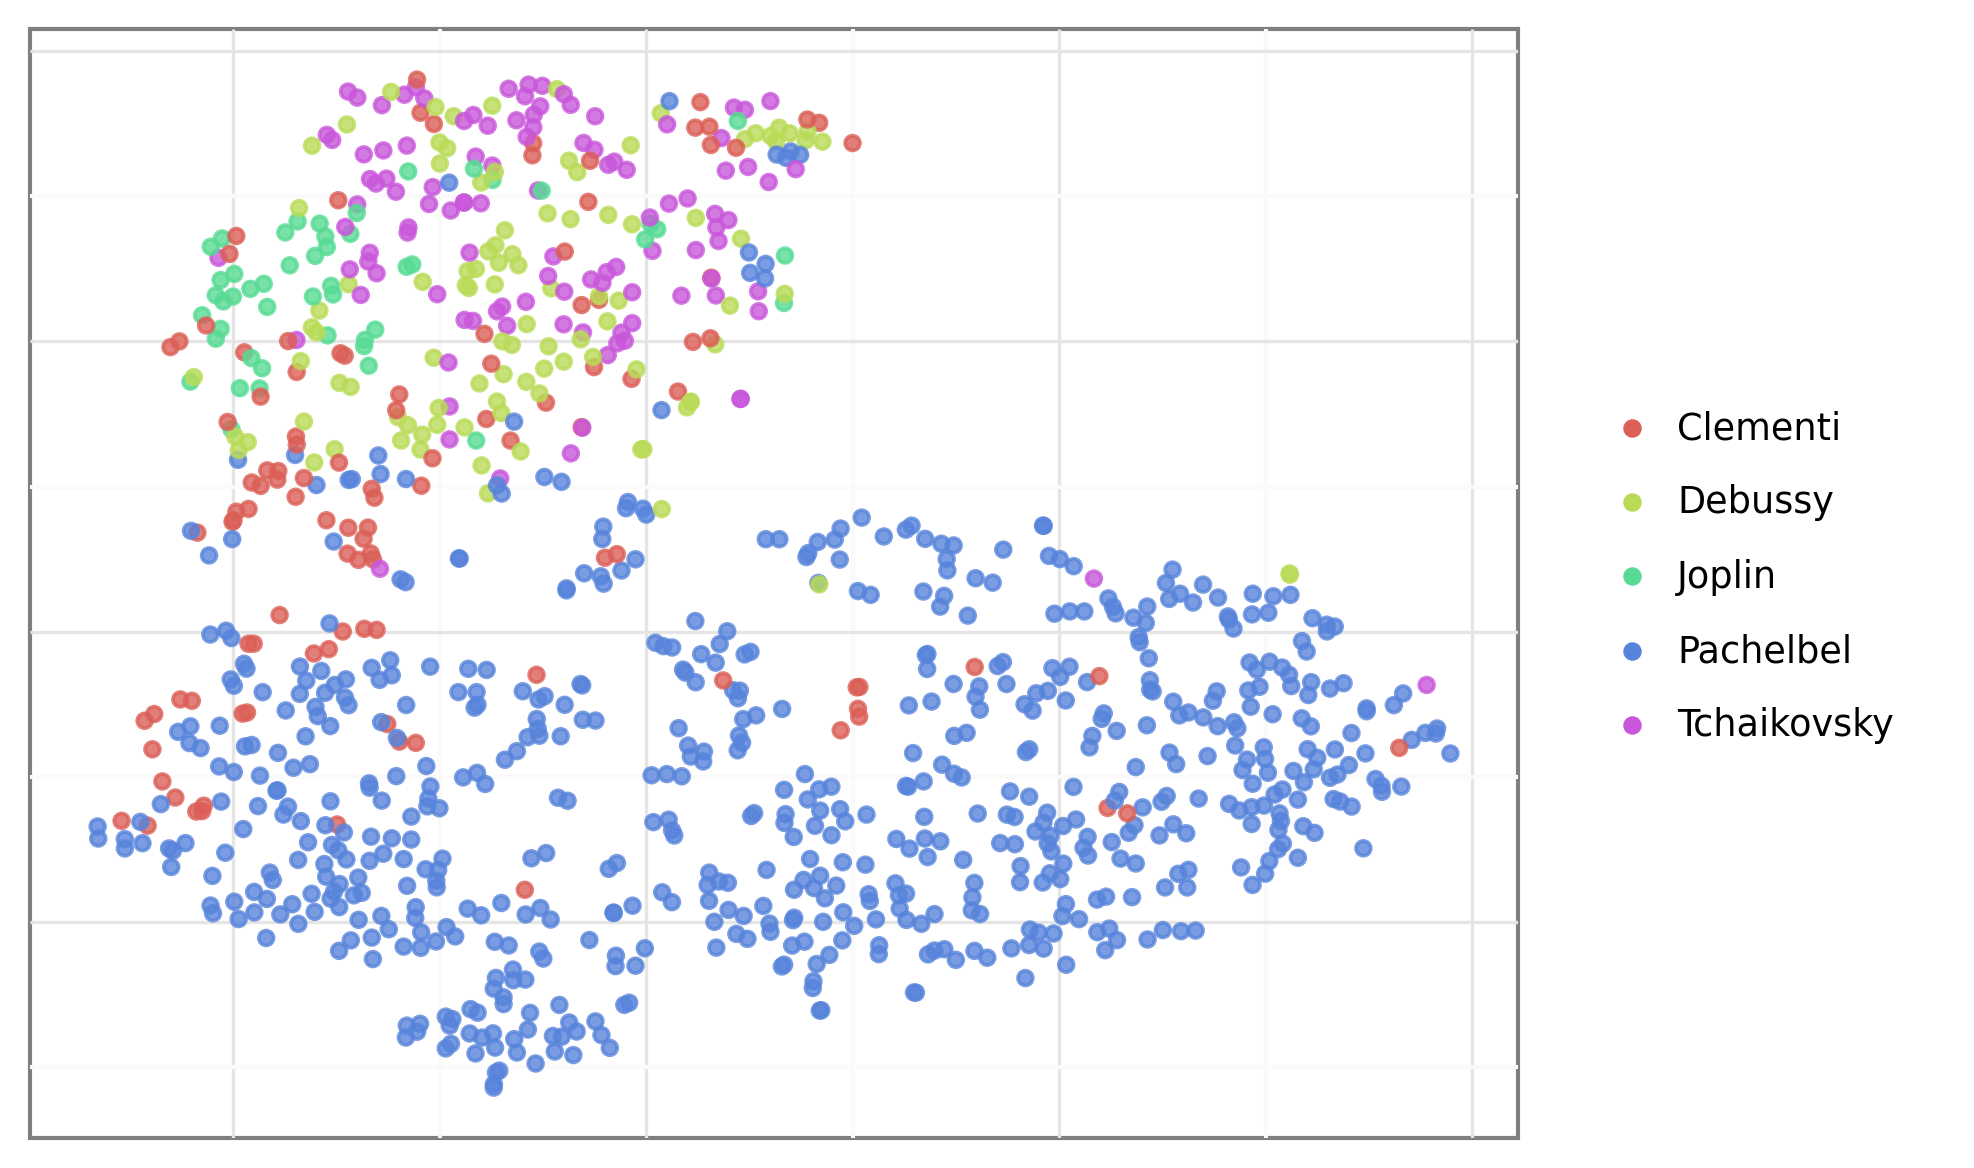

<ggplot: (-9223363244392081229)>

In [50]:
plot_tSNE(points, labels)